In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df.head()

,start_time,end_time,total_time_hours
date,,,
2021-02-23,2021-02-23 13:00:00,2021-02-23 16:00:00,3.0
2021-03-29,2021-03-29 10:00:00,2021-03-29 13:00:00,3.0
2021-04-22,2021-04-22 08:30:00,2021-04-22 11:30:00,3.0
2021-04-29,2021-04-29 11:30:00,2021-04-29 14:30:00,3.0
2021-05-15,2021-05-15 17:30:00,2021-05-15 19:00:00,1.5


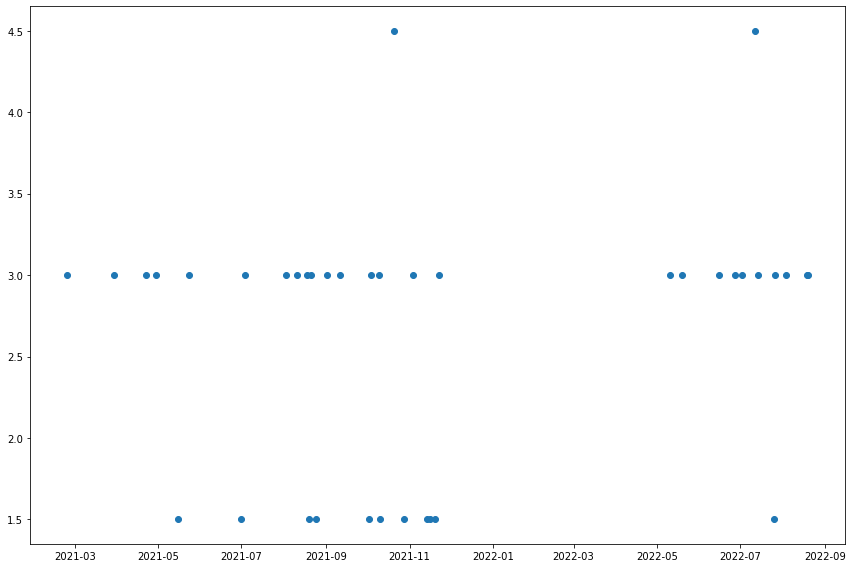

In [3]:
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.start_time, df.total_time_hours)
plt.tight_layout()
plt.show()

In [4]:
df = df.drop(['start_time', 'end_time'], axis=1)

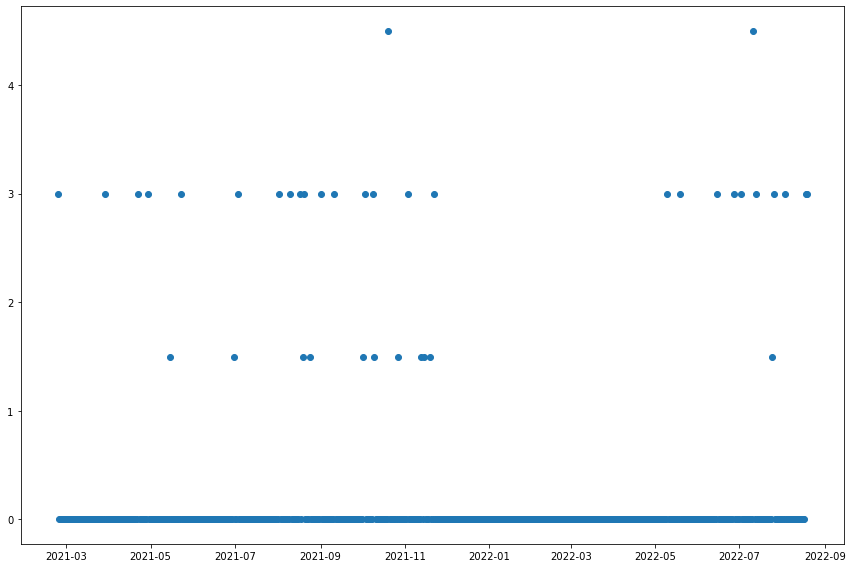

In [5]:
df = df.resample('D').mean().replace(np.nan, 0)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.index, df)
plt.tight_layout()
plt.show()

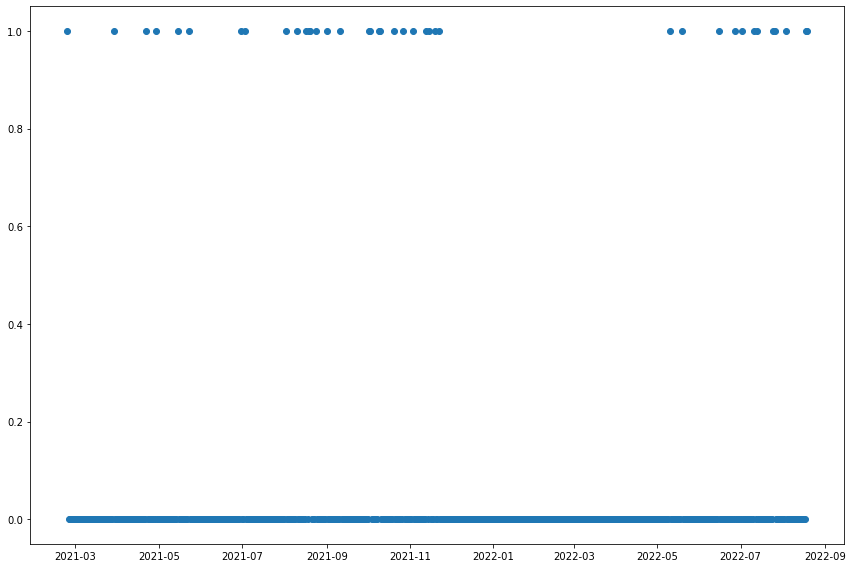

In [6]:
df_binary = df.copy()
df_binary[df_binary > 0] = 1
df_binary.rename(columns={'total_time_hours': 'booked'}, inplace=True)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df_binary.index, df_binary)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

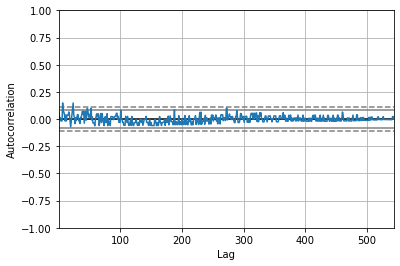

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_binary['booked'])

In [8]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_binary.booked.to_numpy(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  543
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -74.844
Date:                Fri, 19 Aug 2022   AIC                            161.688
Time:                        16:01:42   BIC                            187.459
Sample:                             0   HQIC                           171.765
                                - 543                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7655      0.032    -24.083      0.000      -0.828      -0.703
ar.L2         -0.5965      0.042    -14.043      0.000      -0.680      -0.513
ar.L3         -0.4299      0.047     -9.116      0.0

In [9]:
forecast = model_fit.forecast(steps=31)
forecast

array([0.40349746, 0.43017565, 0.47127892, 0.52879272, 0.62432348,
       0.58177584, 0.51649405, 0.52761836, 0.53950544, 0.54987945,
       0.55572547, 0.54657237, 0.54044729, 0.54322773, 0.54539544,
       0.54651855, 0.54636022, 0.54498961, 0.54459101, 0.5451227 ,
       0.54541911, 0.54547378, 0.54535157, 0.54518902, 0.54519503,
       0.54527892, 0.54530868, 0.54529964, 0.54527561, 0.545261  ,
       0.54526893])

In [10]:
df_binary.iloc[-1]

booked    1.0
Name: 2022-08-19 00:00:00, dtype: float64

In [11]:
dates_forward = [{'date': datetime.today() + timedelta(days=i), 'booked': forecast[i-1]} for i in range(1, len(forecast))]
print(f"Most likely day to to book laundry slot: {dates_forward[np.argmax(forecast)]['date'].date()} ")

Most likely day to to book laundry slot: 2022-08-24 


In [12]:
preds = pd.DataFrame.from_dict(dates_forward).set_index('date')

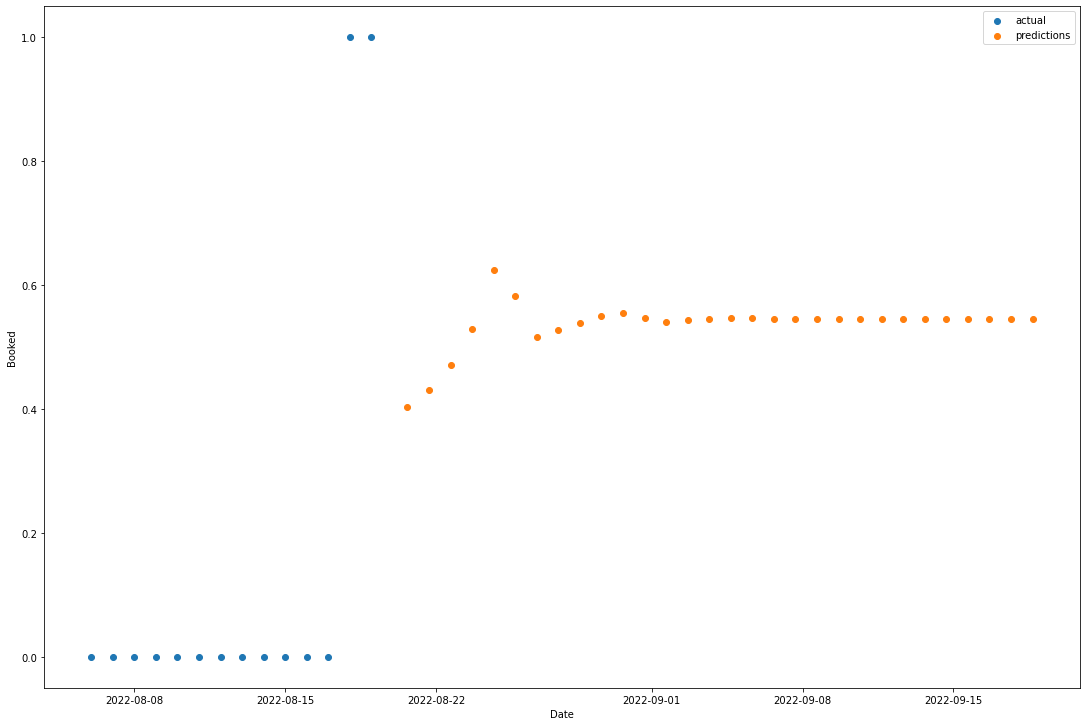

In [13]:
from datetime import date


fig = plt.figure(figsize=(15, 10))

smaller_window = df_binary.index > datetime.today() - timedelta(days=14)

plt.scatter(df_binary[smaller_window].index, df_binary[smaller_window], label='actual')
plt.scatter(preds.index, preds, label='predictions')
plt.tight_layout()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Booked')
plt.show()